In [2]:
import numpy as np
import pandas as pd
import time

import os
import json
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from pathlib import Path

#for dirname, _, filenames in os.walk('/kaggle/input'):
for dirname, _, filenames in os.walk("input"):
    print(dirname)

input
input\evaluation
input\test
input\training


In [3]:
#data_path = Path('/kaggle/input/abstraction-and-reasoning-challenge/')
data_path = Path('input/')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'
training_tasks = sorted(os.listdir(training_path))
eval_tasks = sorted(os.listdir(evaluation_path))

In [4]:
#已解決的ID
solved_id=set()
solved_eva_id=set()

In [5]:
T = training_tasks
Trains = []
for i in range(400):
    task_file = str(training_path / T[i])
    task = json.load(open(task_file, 'r'))
    Trains.append(task)
    
E = eval_tasks
Evals= []
for i in range(400):
    task_file = str(evaluation_path / E[i])
    task = json.load(open(task_file, 'r'))
    Evals.append(task)

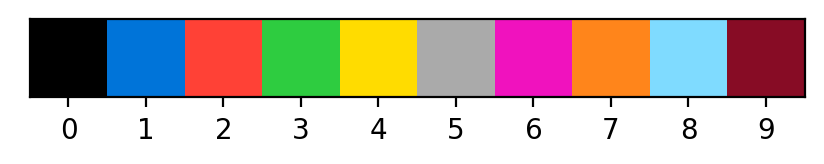

In [6]:
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
# 0:black, 1:blue, 2:red, 3:greed, 4:yellow,
# 5:gray, 6:magenta, 7:orange, 8:sky, 9:brown
plt.figure(figsize=(5, 2), dpi=200)
plt.imshow([list(range(10))], cmap=cmap, norm=norm)
plt.xticks(list(range(10)))
plt.yticks([])
plt.show()

def plot_task(task):
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=50)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0
    
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    for i, t in enumerate(task["test"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Test-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    
    plt.tight_layout()
    plt.show()

In [7]:

def plot_picture(x):
    plt.imshow(np.array(x), cmap = cmap, norm = norm)
    plt.show()

In [8]:
def Defensive_Copy(A): 
    if type(A)!=list:
        A=A.tolist()
    n = len(A)
    k = len(A[0])
    L = np.zeros((n,k), dtype = int)
    for i in range(n):
        for j in range(k):
            L[i,j] = 0 + A[i][j]
    return L.tolist()

In [9]:
def Create(task, task_id = 0):
    n = len(task['train'])
    Input = [Defensive_Copy(task['train'][i]['input']) for i in range(n)]
    Output = [Defensive_Copy(task['train'][i]['output']) for i in range(n)]
    Input.append(Defensive_Copy(task['test'][task_id]['input']))
    return Input, Output

In [10]:
def getObjectHash(pixmap):
    flat = pixmap.flatten().astype(np.bool)
    mult = np.array([2 ** x for x in range(len(flat))])
    return np.sum(flat * mult)
#經測試沒有overflow問題
def groupByColor(pixmap):
    nb_colors = int(pixmap.max()) + 1
    splited = [(pixmap == i) * i for i in range(1, nb_colors)]
    return [x for x in splited if np.any(x)]
def checkColorMap(a0,b0):
    a=np.array(a0)
    b=np.array(b0)
    a[a==0]=10
    b[b==0]=10
    c = 1
    inp_hashes = sorted([getObjectHash(pm) for pm in groupByColor(a)])
    out_hashes = sorted([getObjectHash(pm) for pm in groupByColor(b)])
    c *= inp_hashes == out_hashes
    return bool(c)
def findColorMap(a,b):
    colormap = {}
    a1=np.array(a).flatten()
    b1=np.array(b).flatten()

    for col, idx in zip(*np.unique(a1,return_index=True)):
        if col in colormap.keys(): continue
        colormap[col] = b1[idx]
    return colormap

def mergedict(dict1):
    dict3={}
    for dict2 in dict1:
        for key in dict2.keys():
            if key not in dict3.keys():
                dict3[key]=dict2[key]
            elif dict3[key]!= dict2[key]:
                return False
    return dict3
def applyColorMap(pixmap, colormap):
    a1=np.array(pixmap)
    for i in range(a1.shape[0]):
        for j in range(a1.shape[1]):
            if a1[i][j] not in colormap: #
                continue #
            a1[i][j]=colormap[pixmap[i][j]]
    return a1.tolist()

In [11]:
#Transformations
def Vert(M):
    n = len(M)
    k = len(M[0])
    ans = np.zeros((n,k), dtype = int)
    for i in range(n):
        for j in range(k):
            ans[i][j] = 0+M[n-1-i][j]
    return ans.tolist()

def Hor(M):
    n = len(M)
    k = len(M[0])
    ans = np.zeros((n,k), dtype = int)
    for i in range(n):
        for j in range(k):
            ans[i][j] = 0+M[i][k-1-j]
    return ans.tolist()

def Rot1(M):
    n = len(M)
    k = len(M[0])
    ans = np.zeros((k,n), dtype = int)
    for i in range(n):
        for j in range(k):
            ans[j][i] = 0 + M[i][k-1-j]
    return ans.tolist()
            
def Rot2(M):
    n = len(M)
    k = len(M[0])
    ans = np.zeros((k,n), dtype = int)
    for i in range(n):
        for j in range(k):
            ans[j][i] = 0 + M[n-1-i][j]
    return ans.tolist()

Geometric = [[Hor, Hor], [Rot2], [Rot1, Rot1], [Rot1], [Vert], [Hor, Rot2], [Hor], [Vert, Rot2]]

def Apply_geometric(S, x):
    if S in Geometric:
        x1 = Defensive_Copy(x)
        for t in S:
            x1 = t(x1)
    return x1


In [12]:
def get_flips(inp):
    result = []
    
    
    for S in Geometric:
        x1 = Defensive_Copy(inp)
        for t in S:
            x1=t(x1)
        result.append(x1)
    
    return result

In [13]:
def Solve_train_test_map(basic_task): 
    # returns -1 if no match is found
    # returns Transformed_Test_Case  if the mathching rule is found
    # for this notebook we only look at mosaics
    Input = [Defensive_Copy(x) for x in basic_task[0]]
    Output = [Defensive_Copy(y) for y in basic_task[1]]
    Test_Case = Input[-1]
    Input = Input[:-1]
    for x, y in zip(Input, Output):
        for x1, y1 in zip(Input, Output):
            if x1!=x and checkColorMap(x,x1)==True:
                colomap=findColorMap(x,x1)
                if applyColorMap(y,colomap)!=y1:
                    return -1
    for x, y in zip(Input, Output):
        if checkColorMap(x,Test_Case)==True:
            colomap1=findColorMap(x,Test_Case)
            return applyColorMap(y,colomap1)
    return -1

55


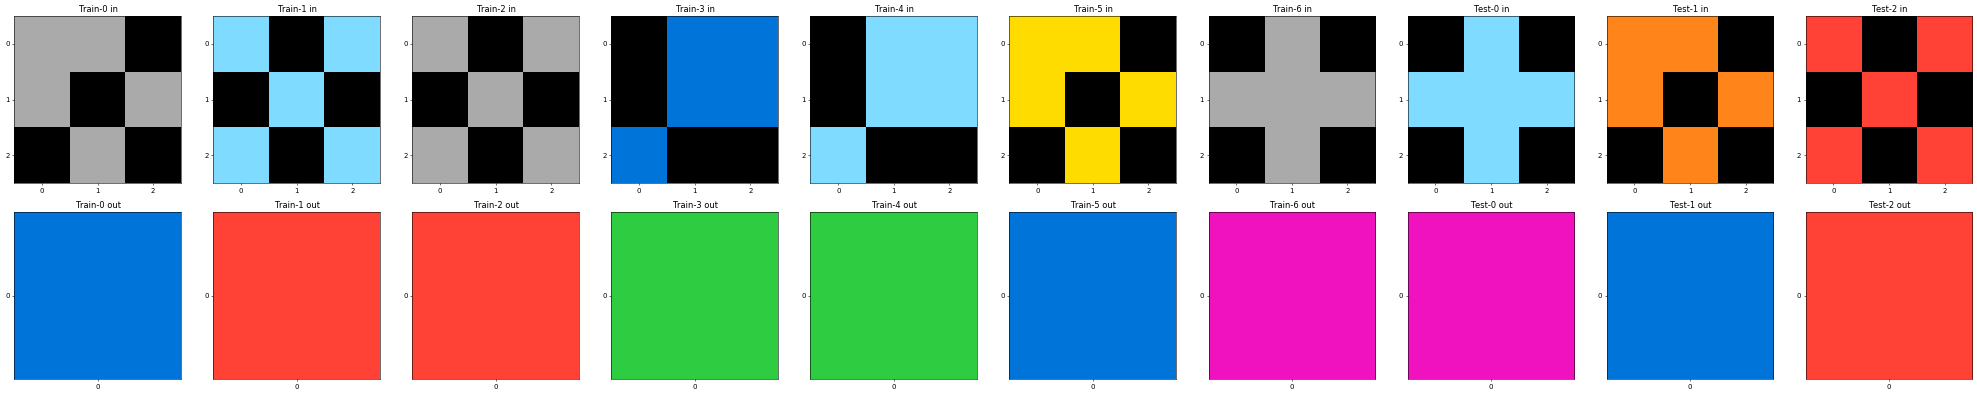

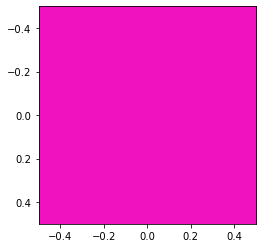

55


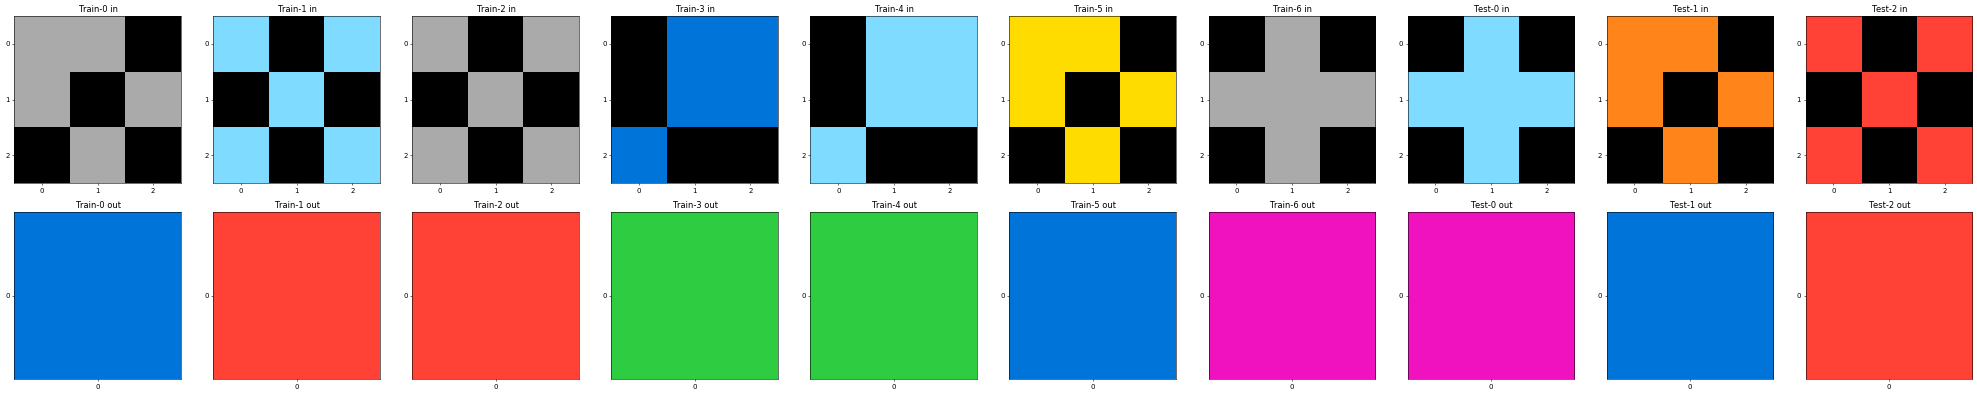

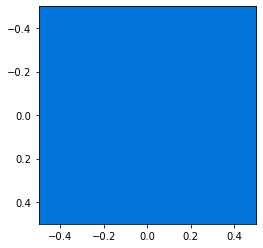

55


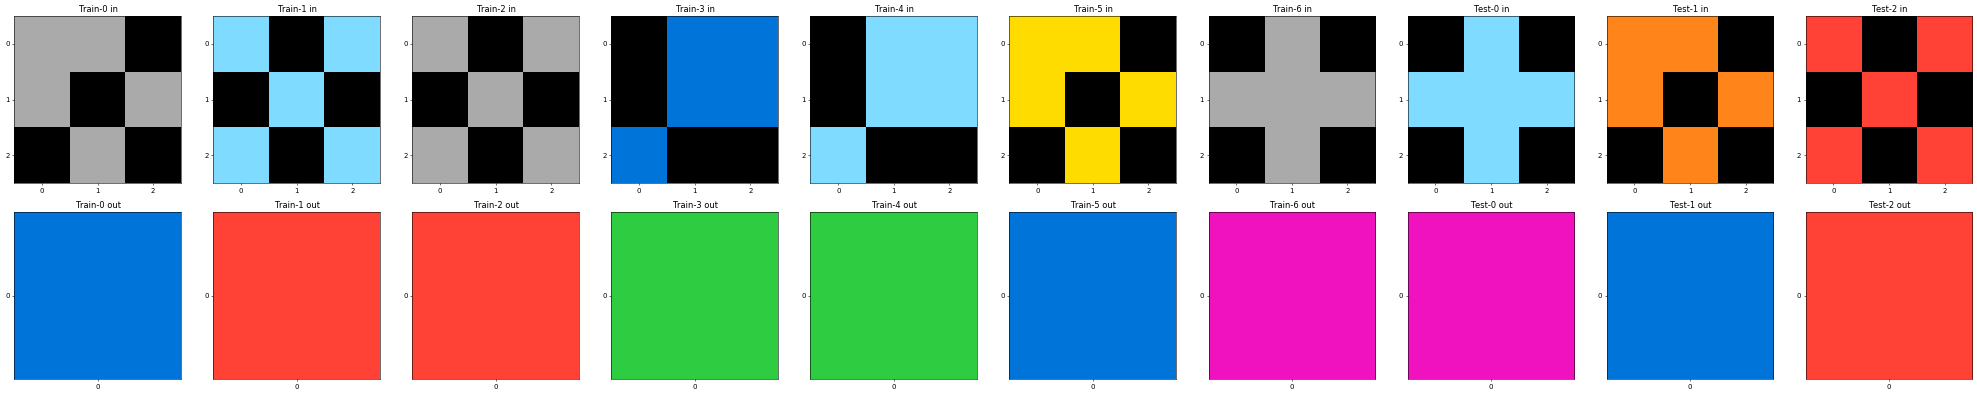

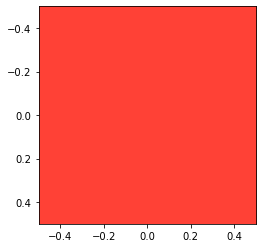

297


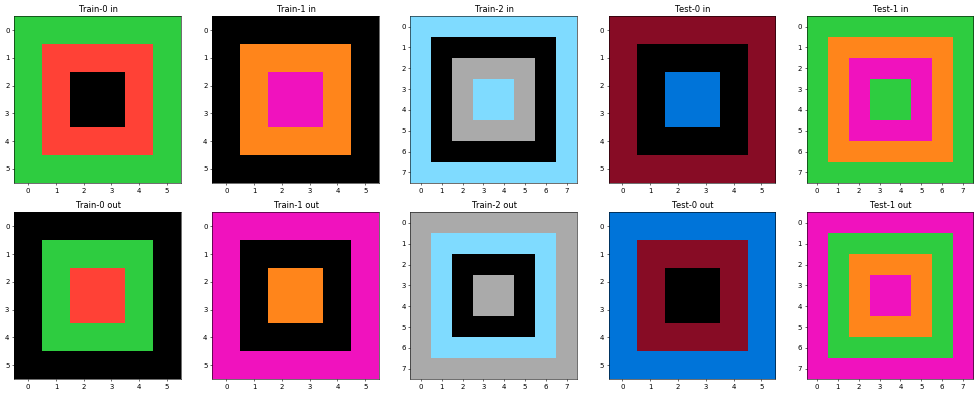

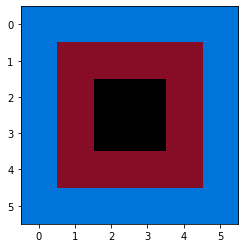

297


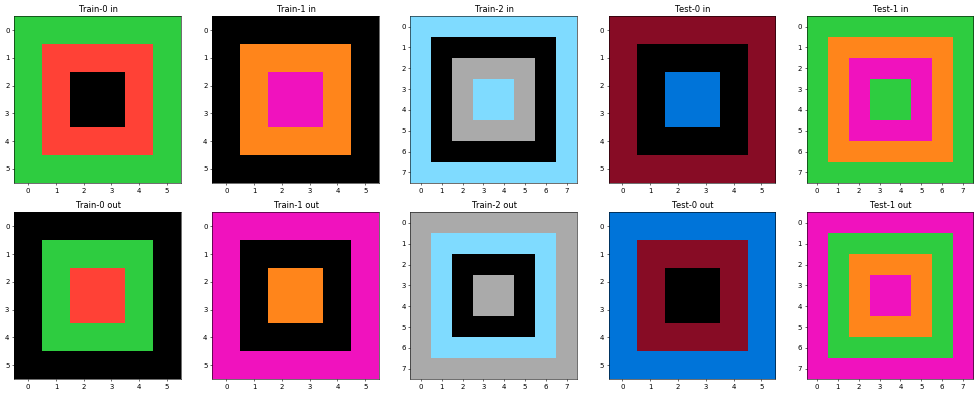

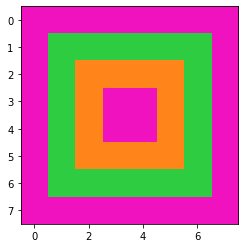

352


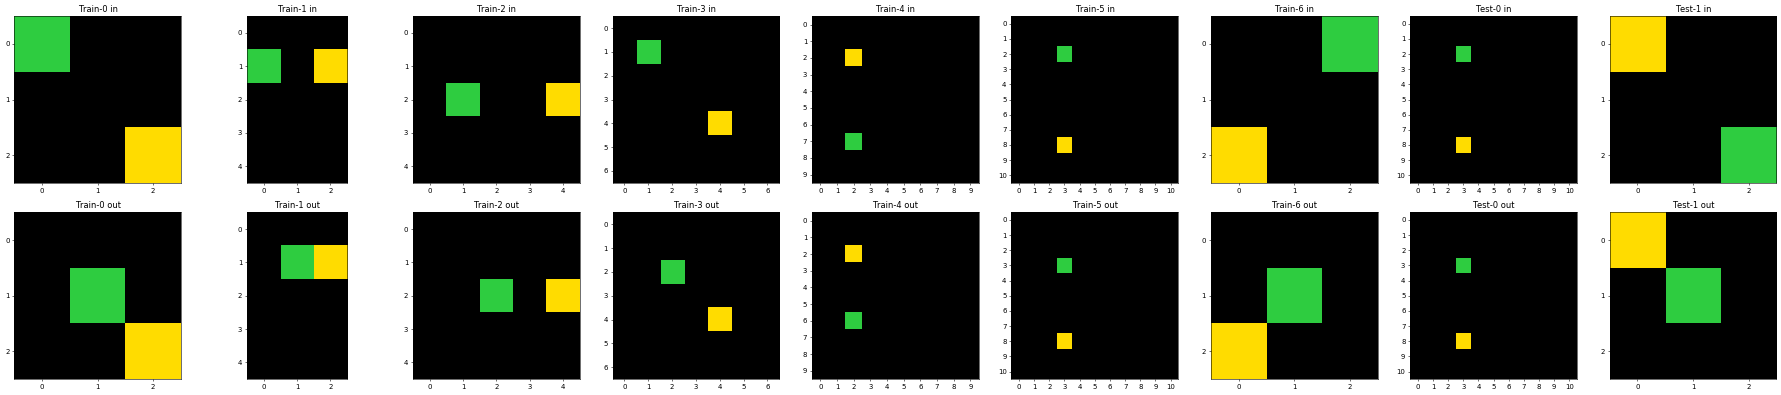

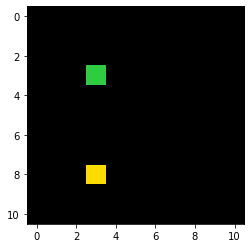

352


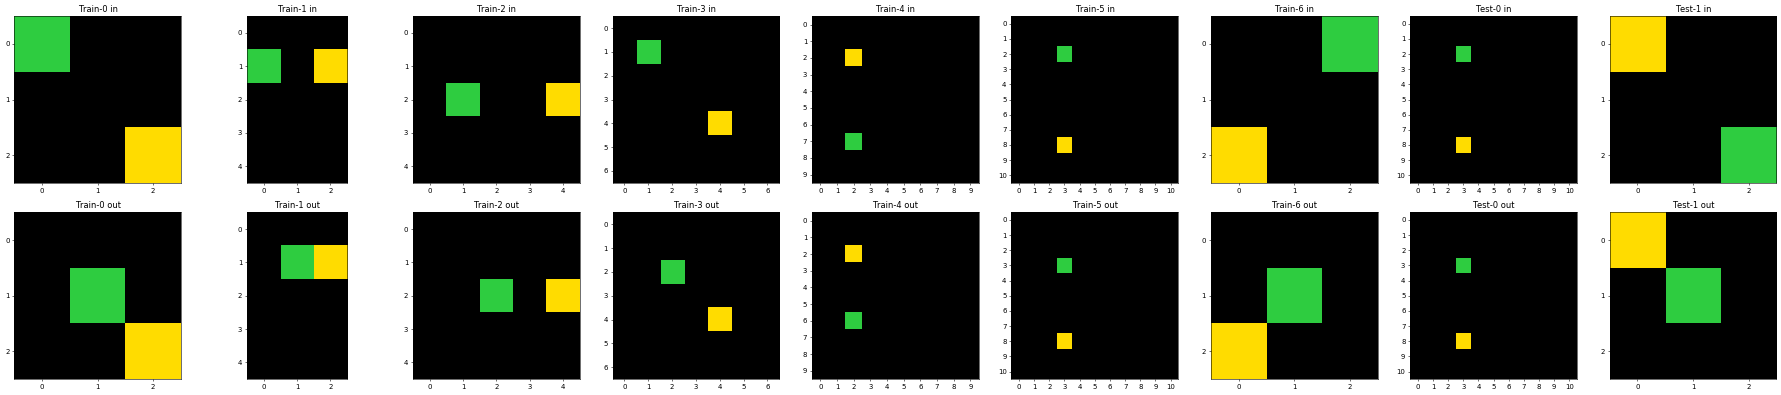

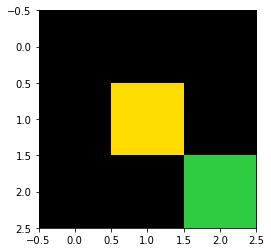

372


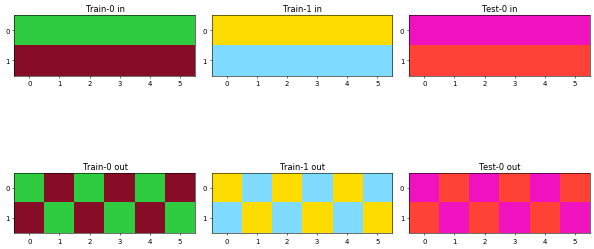

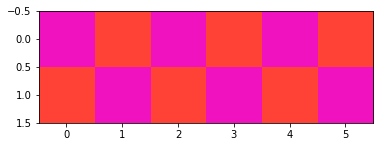

In [14]:
#352 wrong
for i in range(400):
    task = Trains[i]
    k = len(task['test'])
    for j in range(k):
        basic_task = Create(task, j)
        a = Solve_train_test_map(basic_task)
        if a!=-1:
            print(i)
            plot_task(task)
            plot_picture(a)

0


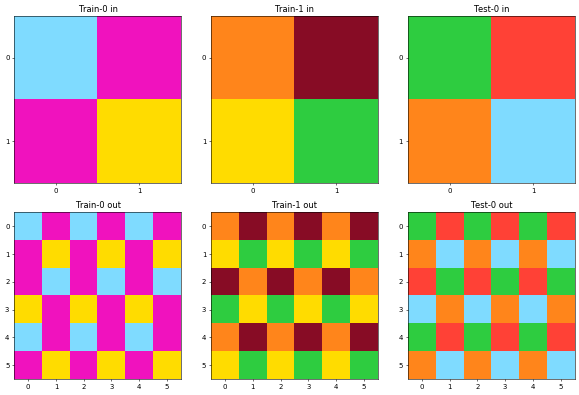

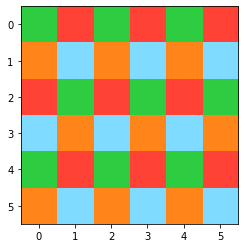

90


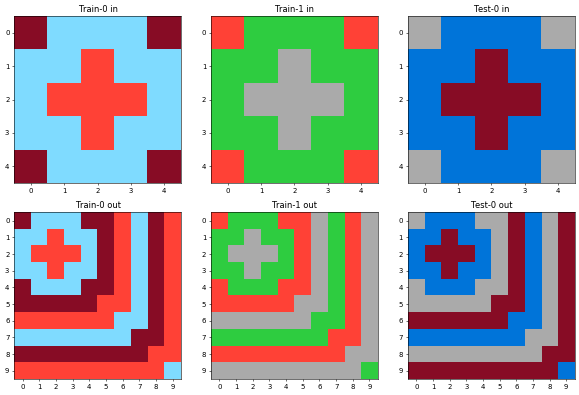

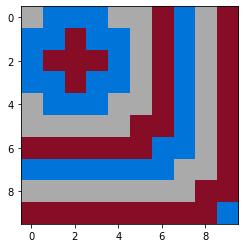

156


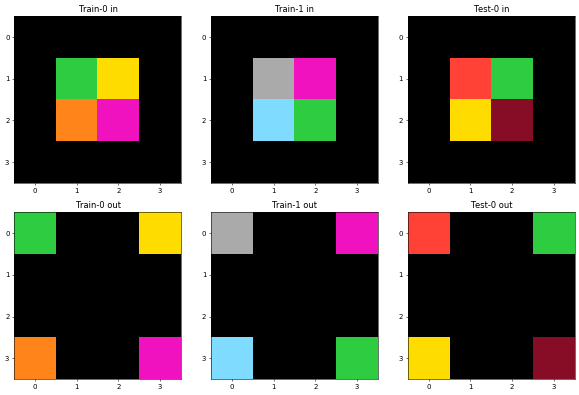

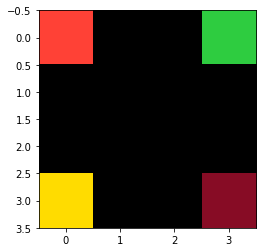

307


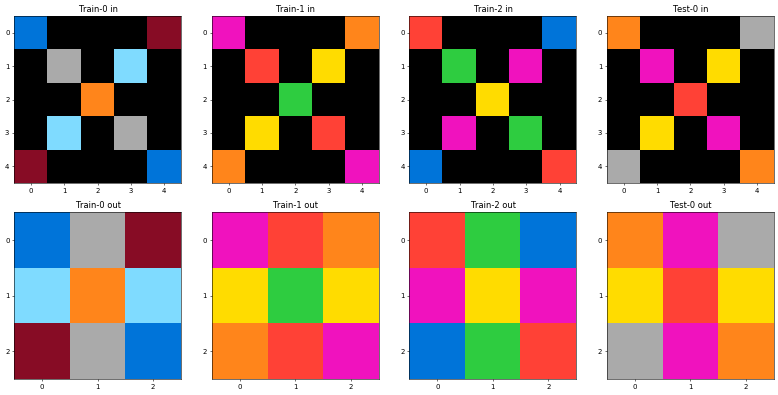

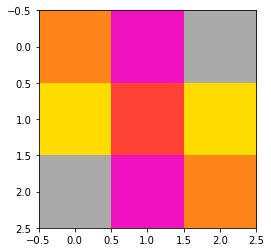

In [15]:

for i in range(400):
    task = Evals[i]
    k = len(task['test'])
    for j in range(k):
        basic_task = Create(task, j)
        a = Solve_train_test_map(basic_task)
        if a!=-1:
            print(i)
            plot_task(task)
            plot_picture(a)

In [16]:
def Solve_train_test_map_flip(basic_task): 
    # returns -1 if no match is found
    # returns Transformed_Test_Case  if the mathching rule is found
    # for this notebook we only look at mosaics
    Input = [Defensive_Copy(x) for x in basic_task[0]]
    Output = [Defensive_Copy(y) for y in basic_task[1]]
    Test_Case = Input[-1]
    Input = Input[:-1]
    Input =[img  for x in Input for img in get_flips(x)]
    Output =[img  for y in Output for img in get_flips(y)]

#     for x, y in zip(Input, Output):
#         for x1, y1 in zip(Input, Output):
#             if x1!=x and checkColorMap(x,x1)==True:
#                 colomap=findColorMap(x,x1)
#                 if applyColorMap(y,colomap)!=y1:
#                     return -1
    for x, y in zip(Input, Output):
        if checkColorMap(x,Test_Case)==True:
#             plot_picture(x)
#             plot_picture(Test_Case)
            colomap1=findColorMap(x,Test_Case)
            return applyColorMap(y,colomap1)
    return -1

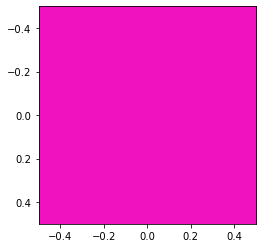

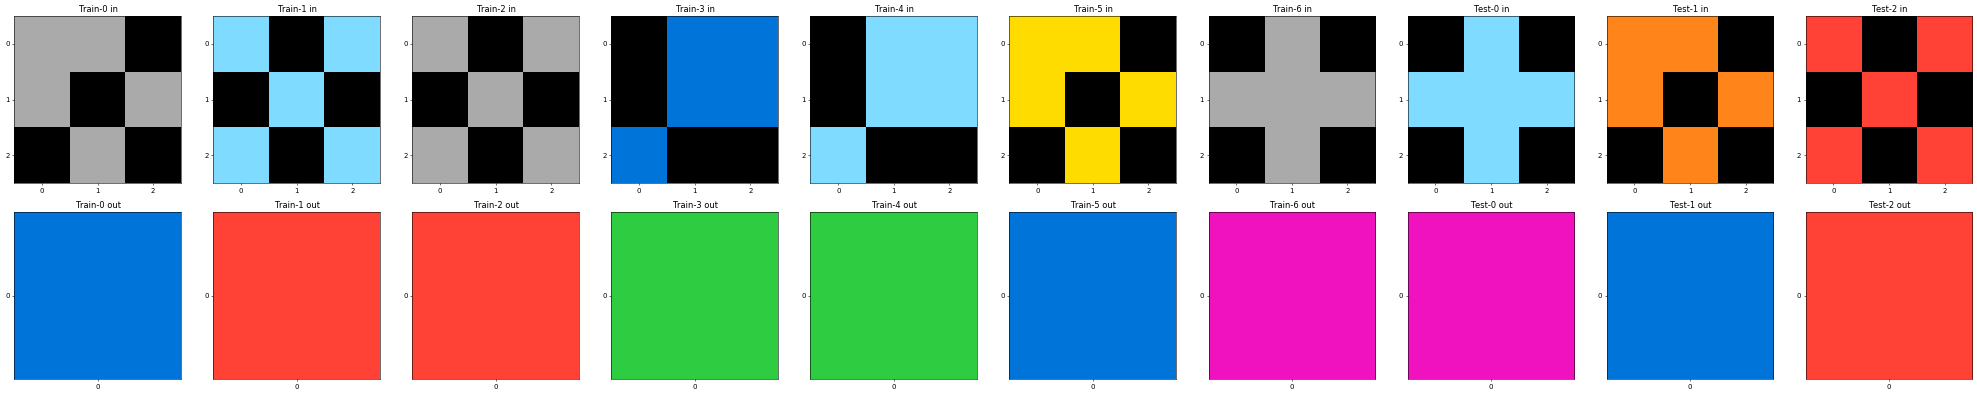

55


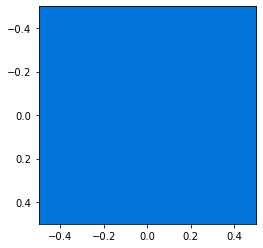

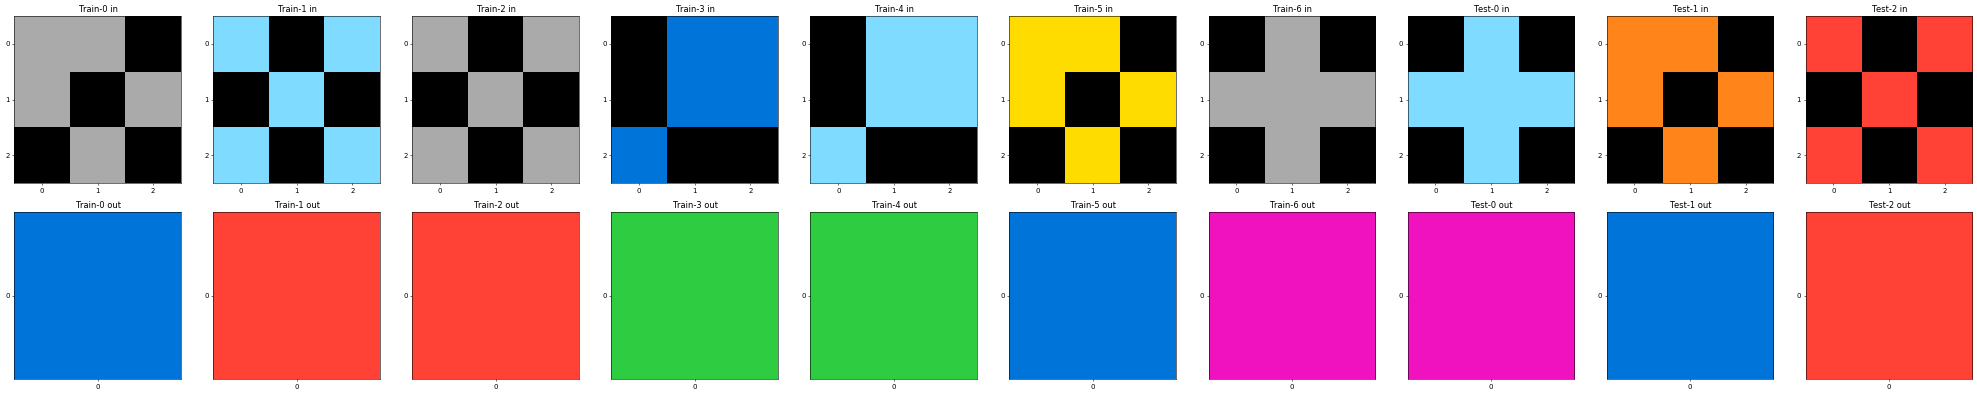

55


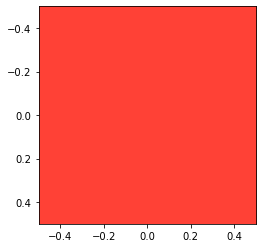

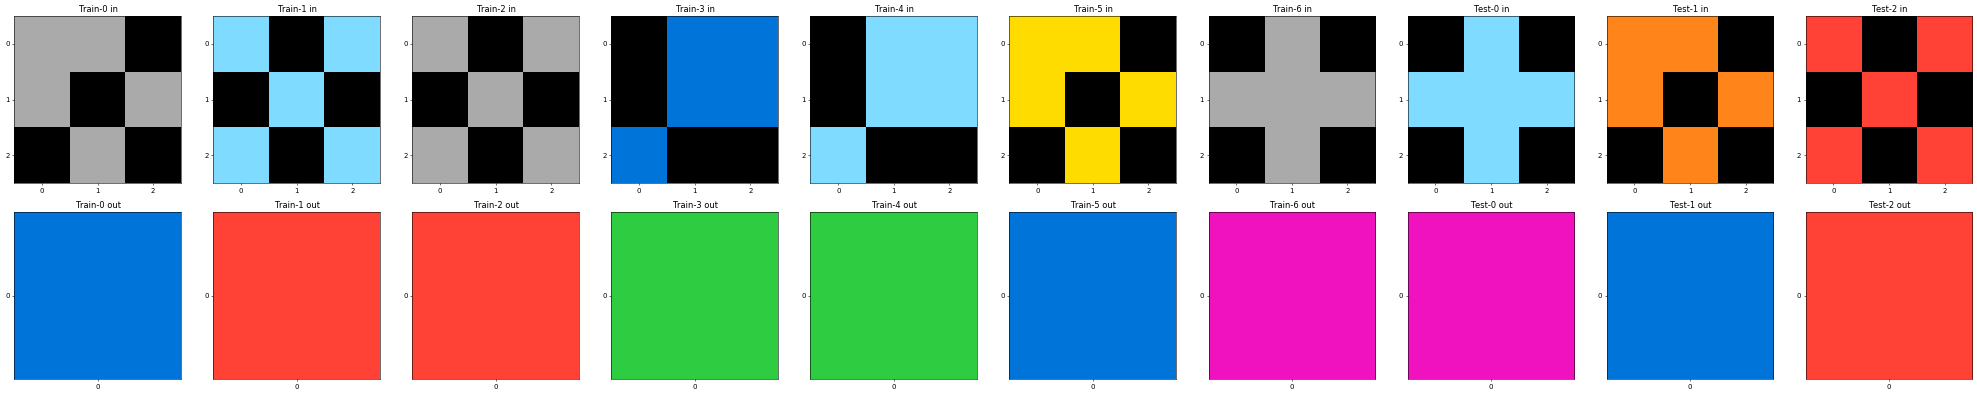

55


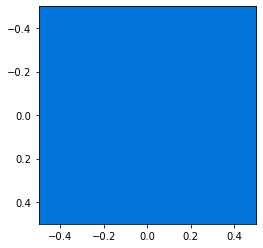

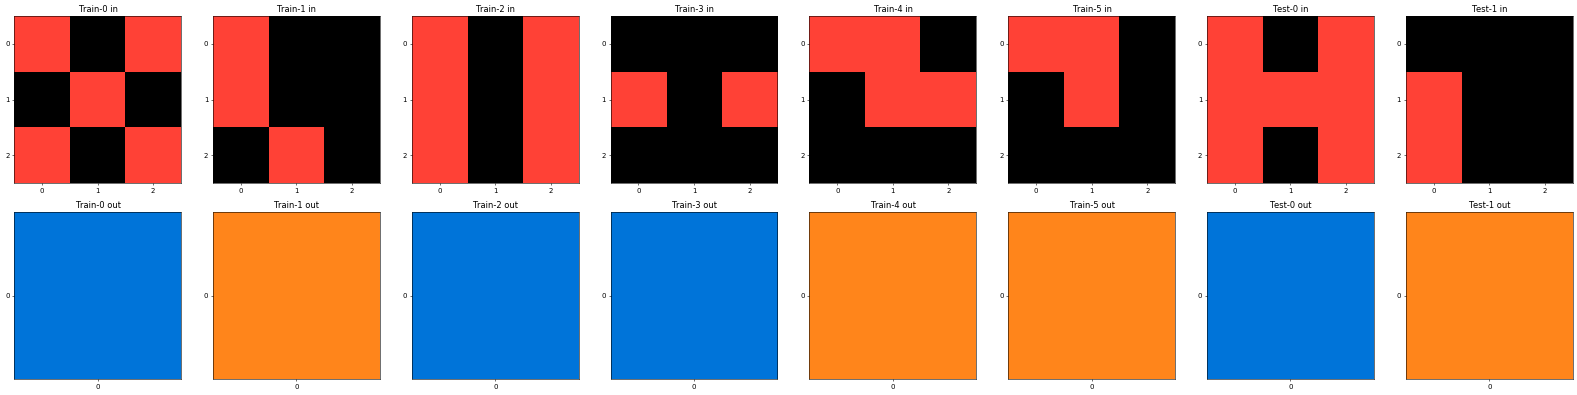

102


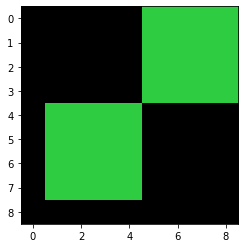

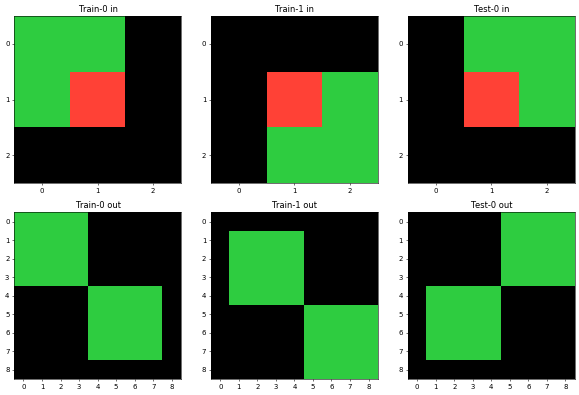

103


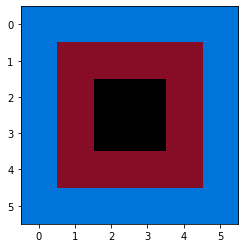

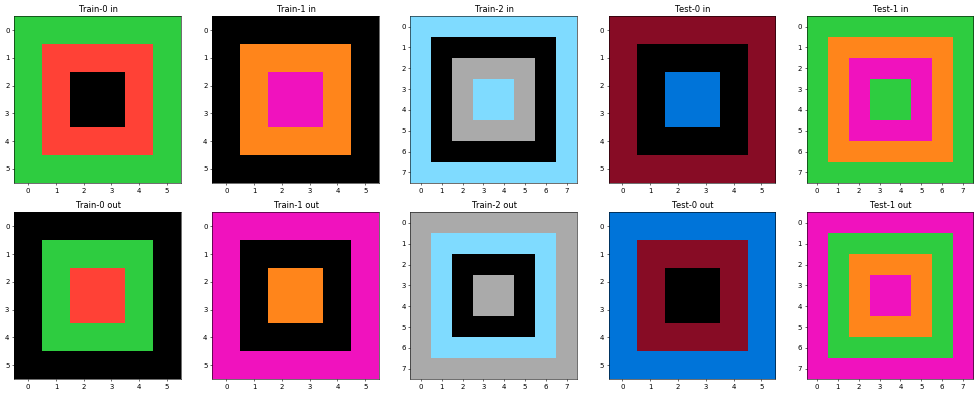

297


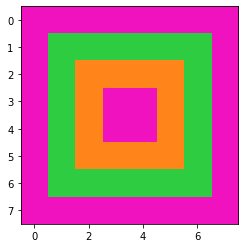

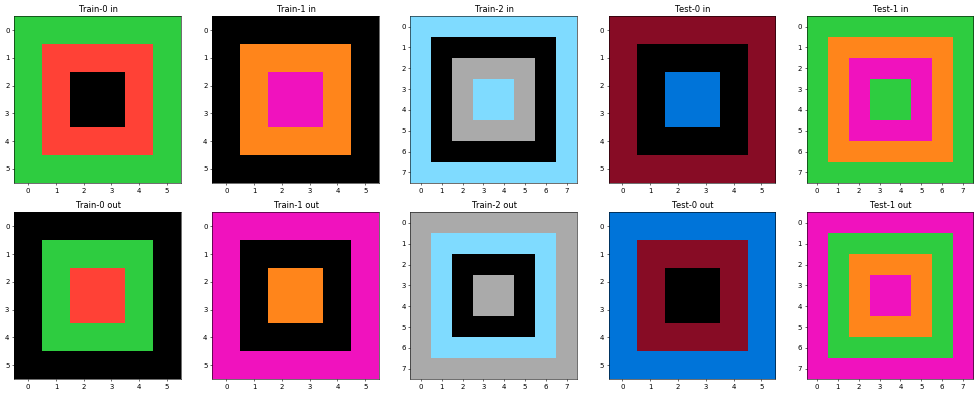

297


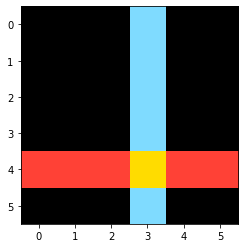

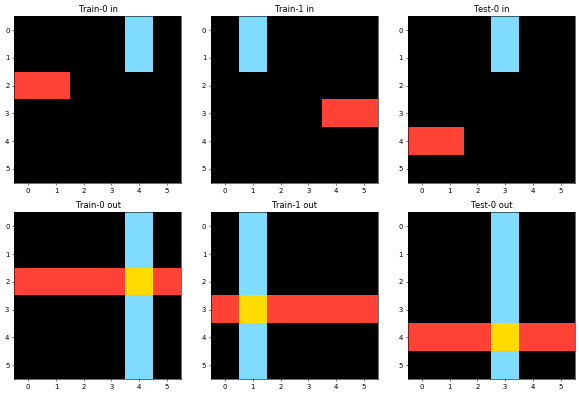

298


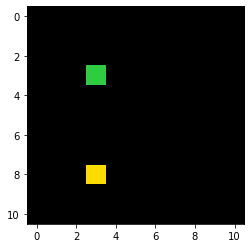

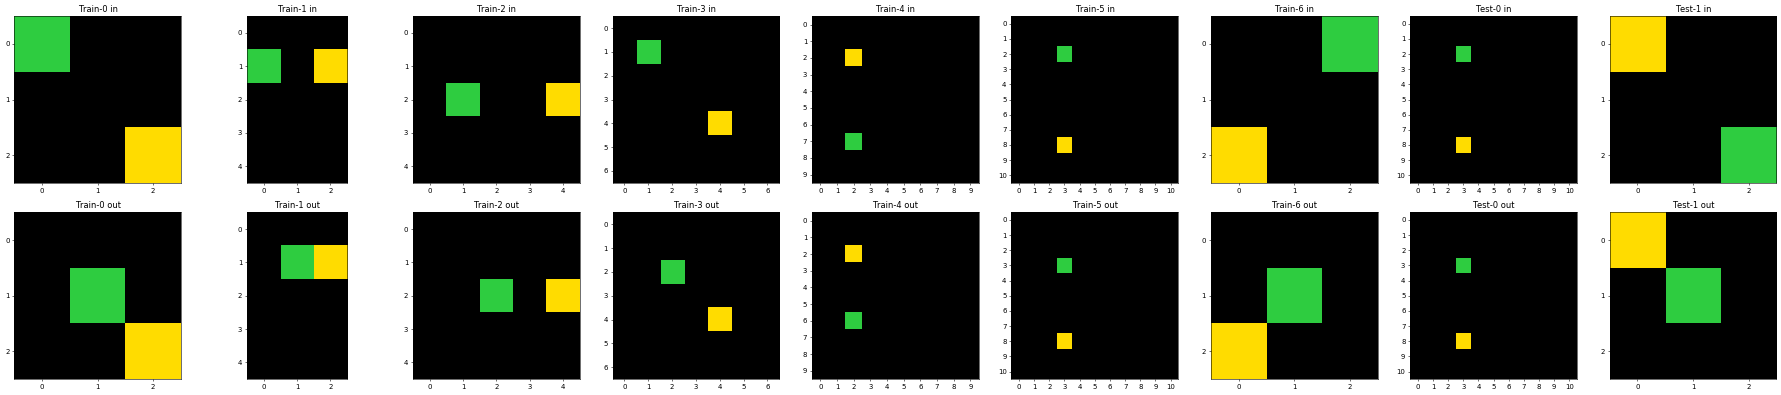

352


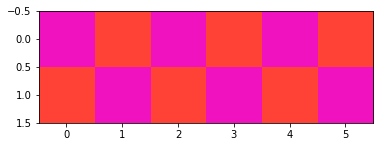

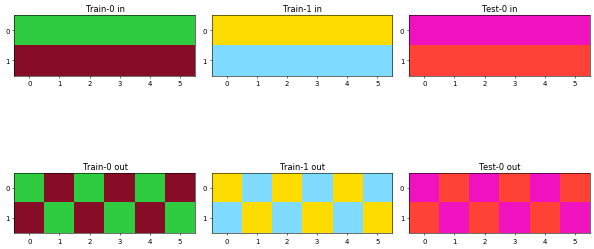

372
10 2


In [17]:
right=0
wrong=0
for i in range(400):
#     print(i)
    task = Trains[i]

    k = len(task['test'])
    for j in range(k):
        basic_task = Create(task, j)
        a = Solve_train_test_map_flip(basic_task)

        if a != -1: 
            if task['test'][j]['output'] == a:
                plot_picture(a)
                plot_task(task)
                print(i)
                right+=1
            else:
                wrong+=1
#                 plot_picture(a)
#                 plot_task(task)
#                 print(i)
print(right,wrong)

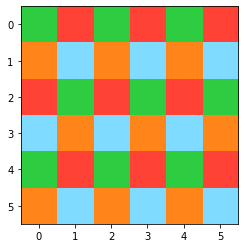

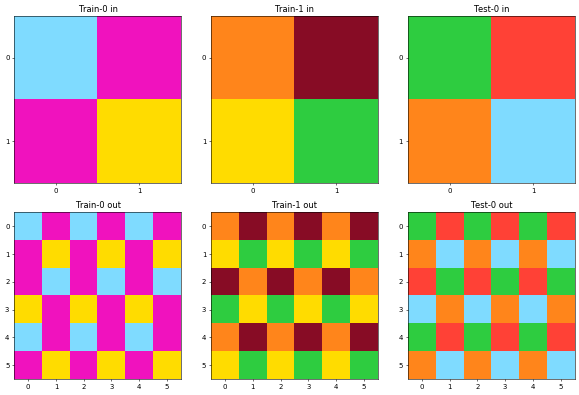

0


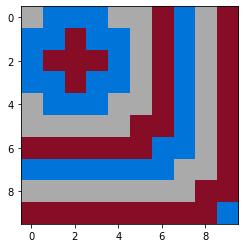

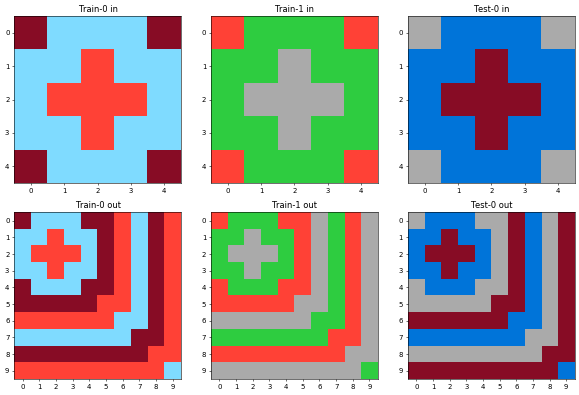

90


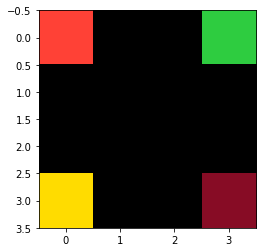

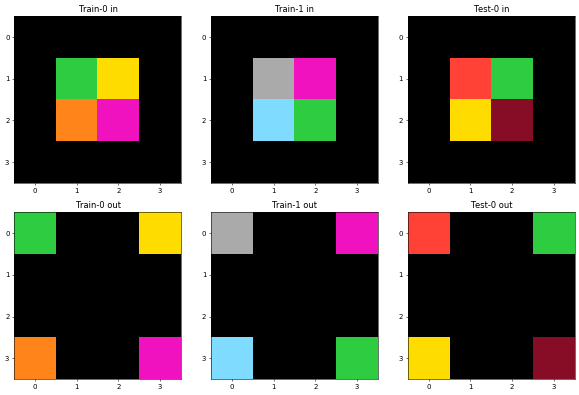

156


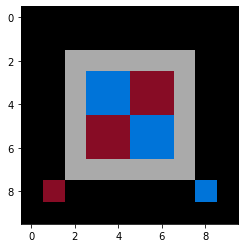

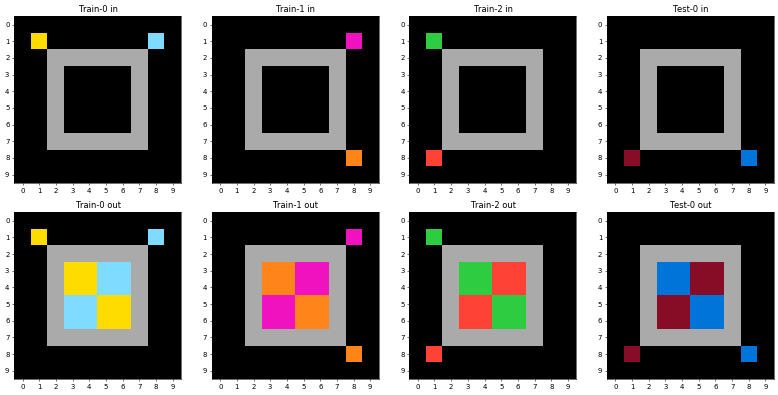

225


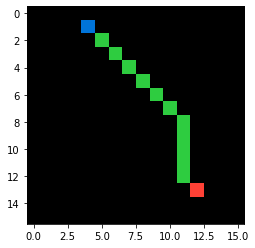

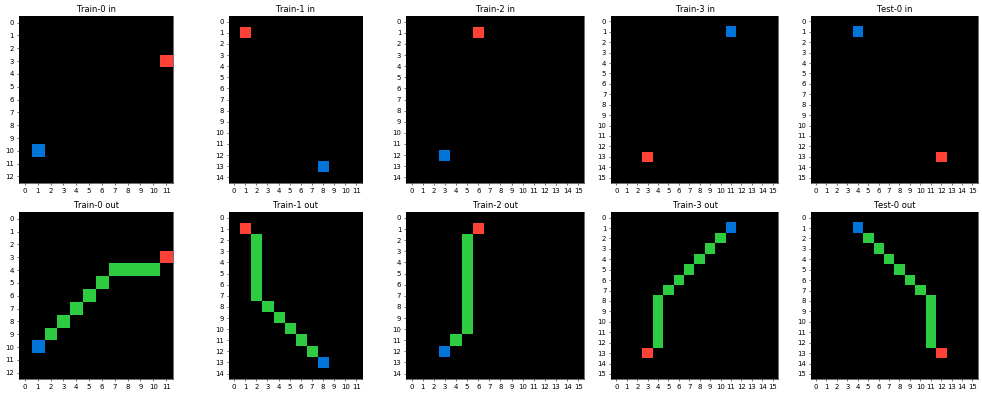

233


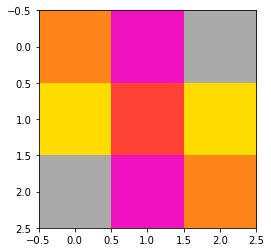

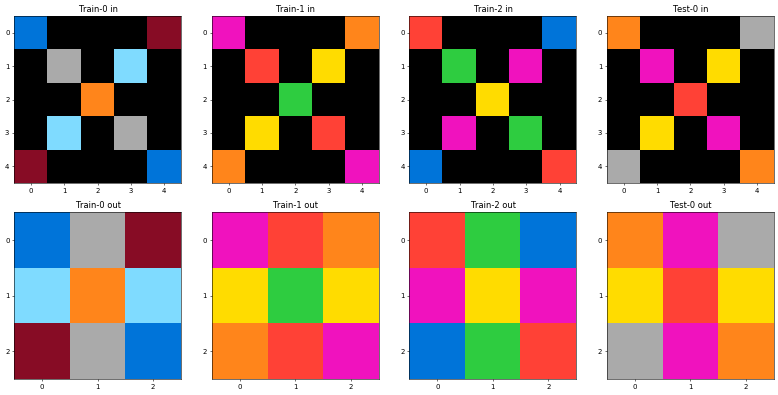

307
6 5


In [18]:
right=0
wrong=0
for i in range(400):
#     print(i)
    task = Evals[i]

    k = len(task['test'])
    for j in range(k):
        basic_task = Create(task, j)
        a = Solve_train_test_map_flip(basic_task)

        if a != -1: 
            if task['test'][j]['output'] == a:
                plot_picture(a)
                plot_task(task)
                print(i)
                right+=1
            else:
                wrong+=1
#                 plot_picture(a)
#                 plot_task(task)
#                 print(i)
print(right,wrong)

In [19]:
BACKGROUND=0
def _get_bound(img0):
    img=np.array(img0)
    h, w = img.shape
    x0 = w - 1
    x1 = 0
    y0 = h - 1
    y1 = 0
    for x in range(w):
        for y in range(h):
            if img[y, x] == BACKGROUND:
                continue
            x0 = min(x0, x)
            x1 = max(x1, x)
            y0 = min(y0, y)
            y1 = max(y1, y)
    return x0, x1, y0, y1
def get_bound_image(img0):
    x0,x1,y0,y1=_get_bound(img0)
    img=np.array(img0)
    return img[y0:y1+1,x0:x1+1].tolist()


In [ ]:
#bound